# Post-analysis

This is how you can analyze your experiment: statistical tests, graphics and reports.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd
import numpy as np
import yaml

sys.path.append('../')

from abacus.auto_ab.abtest import ABTest
from abacus.auto_ab.params import ABTestParams
from abacus.auto_ab.params import DataParams, HypothesisParams

logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

## Case: continuous metric

In [50]:
df = pd.read_csv('./data/ab_data.csv')

In [51]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    covariate='height_prev'
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided',
    metric_type='continuous', 
    metric_name='median', 
    n_buckets=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [52]:
ab_test = ABTest(df, ab_params)
ab_test_1 = ab_test.cuped()
ab_test_2 = ab_test_1.bucketing()

In [53]:
print(f"bootstrap_test: {ab_test_2.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test_2.test_mannwhitney()}")
print(f"welch_test: {ab_test_2.test_welch()}")

bootstrap_test: {'stat': None, 'p-value': 0.5840623294432349, 'result': 0}
mannwhitney_test: {'stat': 505913.0, 'p-value': 0.6470488383496038, 'result': 0}
welch_test: {'stat': -0.6969942886384672, 'p-value': 0.4858874796138488, 'result': 0}


In [54]:
ab_test_2.report()


Parameters of experiment:
- Metric type: continuous.
- Metric: median.
- Errors: alpha = 0.05, beta = 0.2.
- Alternative: two-sided.

Control group:
- Observations: 1000
- Mean: 174.9928
- Median: 174.9791
- 25th quantile: 174.8312
- 75th quantile: 175.1597
- Minimum: 174.2099
- Maximum: 175.7511
- St.deviation: 0.2313
- Variance: 0.0535

Treatment group:
- Observations: 1000
- Mean: 174.9855
- Median: 174.9860
- 25th quantile: 174.8165
- 75th quantile: 175.1452
- Minimum: 174.3255
- Maximum: 175.7856
- St.deviation: 0.2313
- Variance: 0.0535

Transformations applied: cuped -> bucketing.

Number of bootstrap iterations: 200.
Number of buckets: 1000.

Following statistical tests are used:
- Welch's t-test: -0.70, p-value = 0.4859, H0 is not rejected.
- Mann Whitney's U-test: 505913.00, p-value = 0.6470, H0 is not rejected.
- Bootstrap test: H0 is not rejected.

All three stat. tests showed that H0 is not rejected.
        


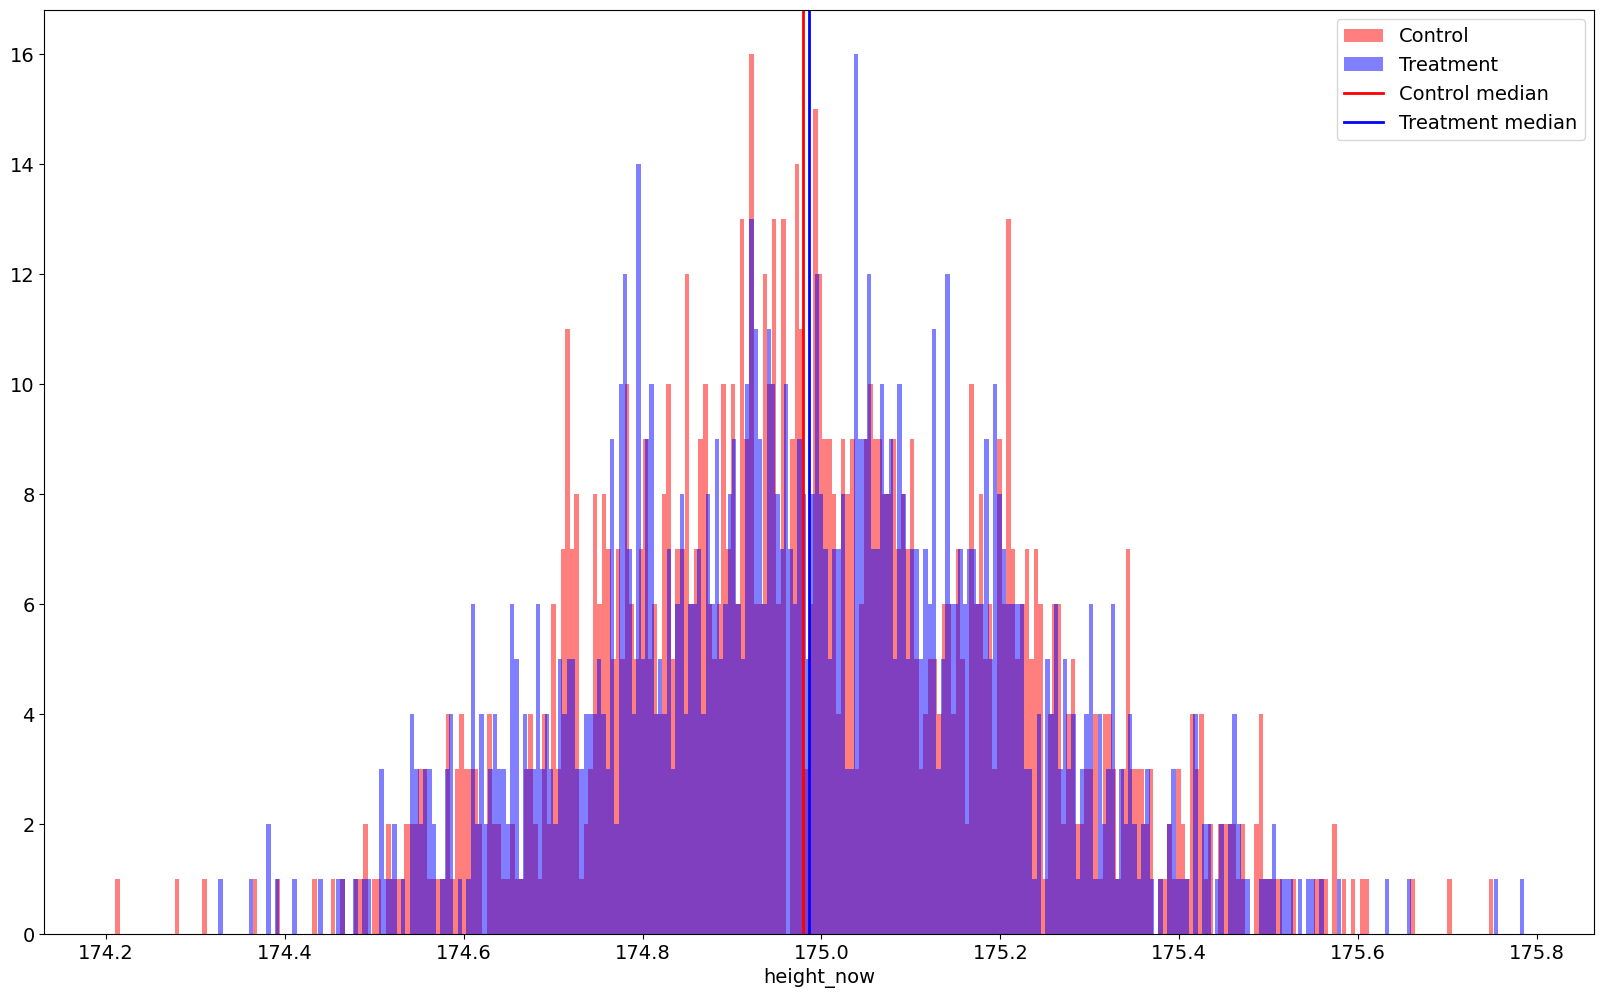

In [55]:
ab_test_2.plot()

## Case: binary metric

In [38]:
df = pd.read_csv('./data/ab_data.csv')

In [39]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    target_flg='conversion'
)


hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    metric_type='binary', 
    metric_name='mean', 
)

ab_params = ABTestParams(data_params,hypothesis_params)

In [40]:
ab_test = ABTest(df, ab_params)

In [42]:
print(f"ztest_test: {ab_test.test_z_proportions()}")

ztest_test: {'stat': 0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}


In [48]:
ab_test.report()


Parameters of experiment:
- Metric type: binary.
- Metric: mean.
- Errors: alpha = 0.05, beta = 0.2.
- Alternative: two-sided.

Control group:
- Observations: 99684
- Conversion: 0.9526503751855865

Treatment group:
- Observations: 100316
- Conversion: 0.9532876111487699

No transformations applied.

Following statistical tests are used:
- Z-test: 0.67, p-value = 0.5009, H0 is not rejected.


0 out of 1 stat.test show that H0 is rejected.
        


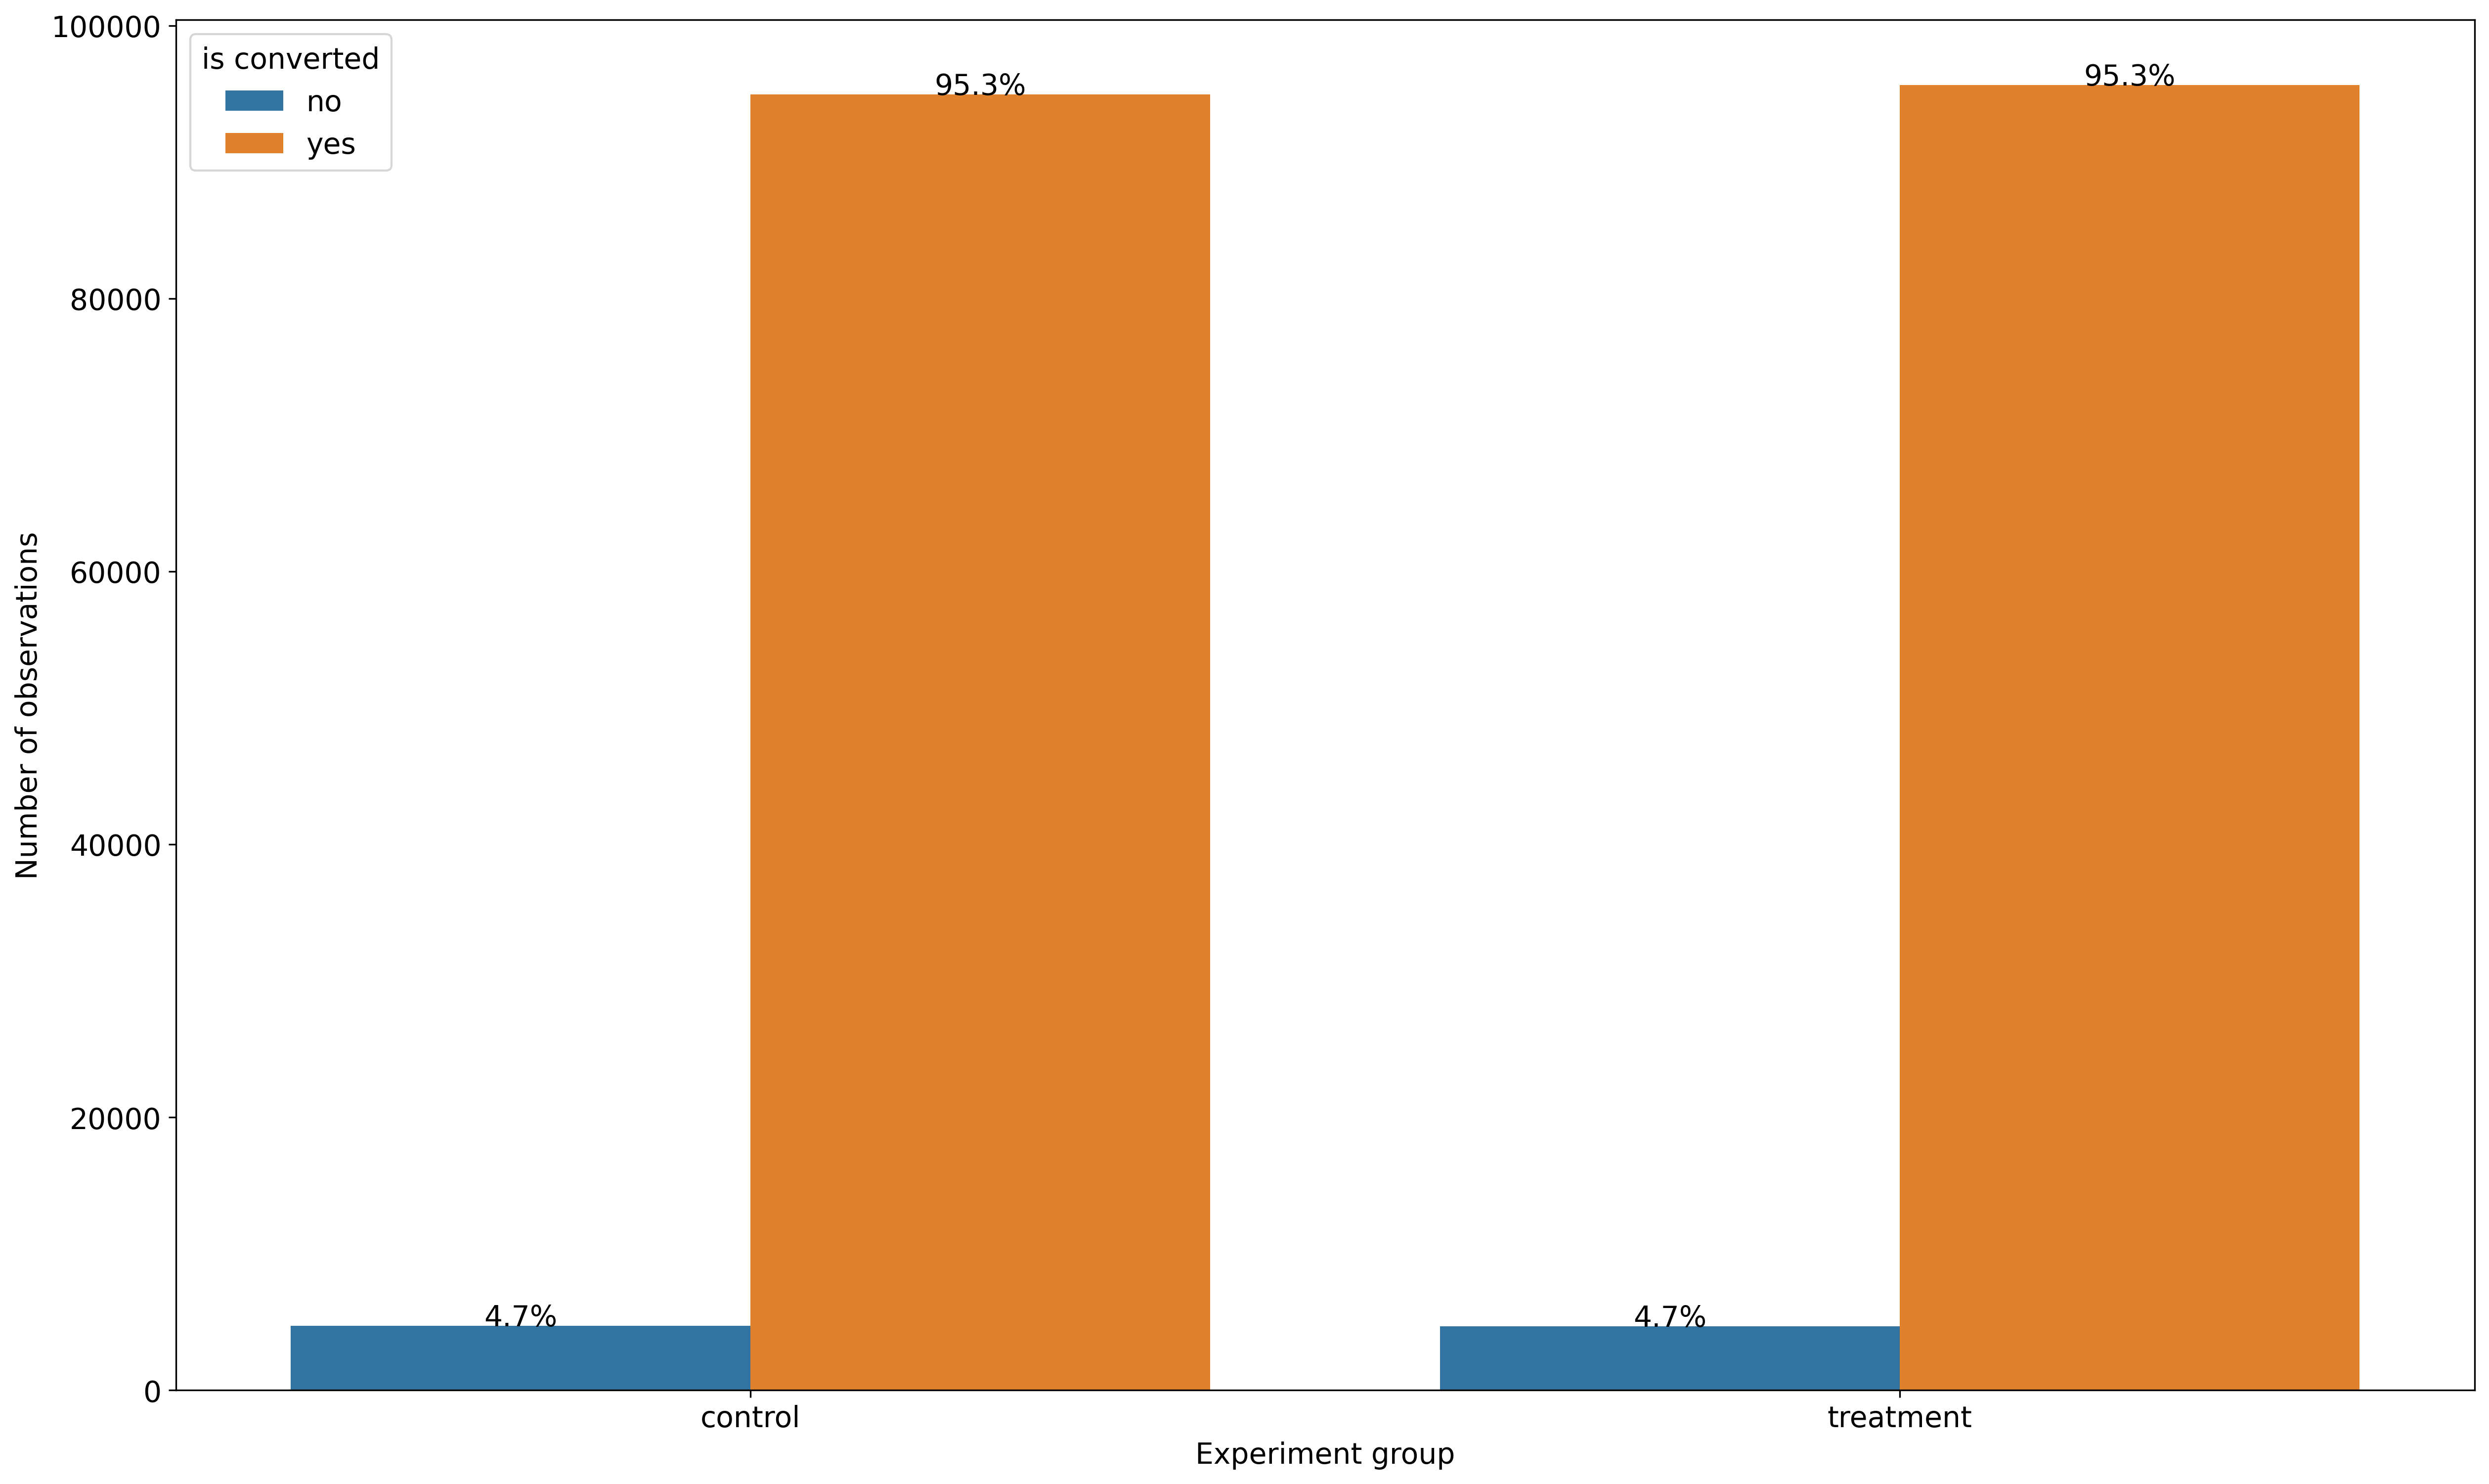

In [49]:
ab_test.plot()